In [1]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sg
import sounddevice as sd
import wavio
import scipy.signal as sig
import time, math, sys
import scipy.fftpack as fft
import pyaudio
import wave
import commpy as cp
import sympy
import time

ModuleNotFoundError: No module named 'pyaudio'

In [2]:
def show_matrix(M):
    plt.imshow(M, cmap=plt.get_cmap('jet'), vmin=0,  extent=(0, M.shape[1], 0, M.shape[0]),
        aspect='equal')
    plt.show()

In [3]:
class Filter(object):
    def __init__(self, b, a = [1], init=[]):
        self.b = b
        self.a = a
        self.clear(init)
    def __call__(self, x):
        y, self.state = sig.lfilter(self.b, self.a, x, zi=self.state)
        return y
    def clear(self, init=[]):
        self.state = sig.lfiltic(self.b, self.a, [], init)

In [4]:
def access_bit(data, num):
    base = int(num // 8)
    shift = int(num % 8)
    return (data[base] >> shift) & 0x1

def get_bits(data):
    return [access_bit(data, i) for i in range(len(data)*8)]

In [5]:
def encode(G, x):
    return x @ G % 2

def decode(H, u, niter):
    print(H.shape)
    u = u.reshape((len(u), 1))
    K = H.shape[1] - H.shape[0]
    for i in range(niter):
        s = (H @ u) % 2
        if np.sum(s) == 0:
            break
        error = np.zeros(u.shape)
        error[np.argmax(s.T @ H)] = 1
        u = (u - error) % 2
    return np.array(u[:K].reshape((K)), dtype=int)

In [6]:
def gen_ldpc_H(n=320, m=160):
    cmax = 10
    rmax = 20
    rng = np.random.default_rng()
    H = np.zeros((m, n))
    top_layer = np.zeros((int(m/cmax), n))
    for i in range(top_layer.shape[0]):
        for j in range(rmax):
            top_layer[i][i * rmax + j] = 1
    H[:top_layer.shape[0]] = top_layer
    
    for i in range(1,cmax):
        rand_layer = rng.permutation(top_layer, axis = 1)
        H[i * top_layer.shape[0]:(i + 1)*top_layer.shape[0]] = rand_layer
    return np.array(H, dtype=int)

In [7]:
def gauss(M):
    H = M.copy()
    m, n = H.shape
    for i in range(m):
        k = np.argmax(H[i:, i]) + i
        if H[k][i] != 1:
            l = np.argmax(H[i])
            tmp = np.copy(H[:, i])
            H[:, i] = H[:, l]
            H[:, l] = tmp
        temp = np.copy(H[k])
        H[k] = H[i]
        H[i] = temp
        for j in range(m):
            if i!=j and H[j][i] == 1:
                H[j] = (H[j]+H[i]) % 2
    return H

def get_Hstd_G(H):
    res = gauss(H)
    res = res[~np.all(res == 0, axis=1)]
    res = gauss(res)
    m,n = res.shape
    res = np.array(res, dtype=int)
    P = res[:, m:]
    return np.hstack([P, np.eye(P.shape[0], dtype=int)]), np.hstack([np.eye(P.shape[1], dtype=int),P.T])

In [8]:
Barker11 = [+1, +1, +1, -1, -1, -1, +1, -1, -1, +1, -1]
H = gen_ldpc_H()
H, G = get_Hstd_G(H)
W_LEN, CW_LEN = G.shape

In [9]:
def spectre(samples, Fs):
    #%matplotlib widget
    for s in samples:
        plt.plot(np.linspace(-Fs/2, Fs/2, len(s)), np.fft.fftshift(20 * np.log10(np.abs(np.fft.fft(s)))))
    plt.savefig('spectre.png')
    plt.show()

In [33]:
def make_sound(file_in, nbits=W_LEN, file_check="tmpcheck.txt", file_channel=None):
    # read bytes from file
    Fc = 7000
    Fs = 48000
    data = []
    with open(file_in, 'rb') as file:
        data = file.read()
    # convert bytes to bits
    bits = get_bits(data)
    bits = bits[:nbits]
    with open(file_check, "wb") as file:
        # Write bytes to file
        print(np.packbits(bits))
        file.write(np.packbits(bits))
    # LDPC encoding
    encoded_bits = encode(G, bits)
    encoded_bits = np.array(encoded_bits, dtype=float)
    # 1 -> -1; 0 -> 1
    signal = 1 - 2*encoded_bits
    # add barker
    data = np.concatenate((Barker11, signal))
    # frequency up
    UP = 48
    N = 4801
    t, rrc = cp.filters.rrcosfilter(N, 0.25, 1e-3, Fs)
    tx = np.zeros(len(data)*UP + len(rrc)*2)
    tx[:len(data)*UP:UP] = data
    UpFilter1 = Filter(rrc)
    # ready to transmit
    tx = UpFilter1(tx) * np.cos(2 * np.pi*Fc/Fs*np.arange(len(tx)))
    tx = np.array(tx, dtype=np.float32)
    if file_channel == None:
        # Initialize PyAudio
        p = pyaudio.PyAudio()
        # Setting output to "True" makes the sound be "played" rather than recorded
        stream = p.open(format = pyaudio.paFloat32,
                        channels = 1,
                        rate = Fs,
                        output = True)
        # delay for mouse clicking
        time.sleep(2)
        # play data
        stream.write(tx)
        # Stop, Close and terminate the stream
        stream.stop_stream()
        stream.close()
        p.terminate()
    else:
        with sf.SoundFile(file_channel, 'w', Fs, channels=1) as output:
            output.write(tx)
    return tx

In [11]:
class StreamReader(object):
    def __init__(self, rate, format_t=pyaudio.paFloat32, channels=1):
        self.format_t = format_t
        self.channels = channels
        self.rate = rate
    def open_stream(self):
        self.p = pyaudio.PyAudio()
        self.stream = self.p.open(format=self.format_t,
                        channels=self.channels,
                        rate=self.rate,
                        input=True)
    def close(self):
        self.stream.stop_stream()
        self.stream.close()
        self.p.terminate()
    def __del__(self):
        self.close()
    def __call__(self, nbits):
        data = self.stream.read(nbits)
        data = np.fromstring(data, dtype=np.float32)
        return data

In [29]:
def get_sound(file_out, w_len=W_LEN, cw_len=CW_LEN, tx=[]):
    N = 4801
    Fs = 48000
    Fc = 7000
    t, rrc = cp.filters.rrcosfilter(N, 0.25, 1e-3, Fs)
    UpFilter2 = Filter(rrc/48)
    
    UP = 48
    N2 = 97
    t, rrc2 = cp.filters.rrcosfilter(N2, 0.25, 1e-3, Fs)
    
    BarkerInt = np.zeros(len(Barker11)*UP)
    BarkerInt[::UP] = Barker11[::-1]
    BarkerFilter = Filter(np.convolve(np.convolve(BarkerInt, rrc2/48), rrc2))
    PowerFilter = Filter(np.abs(BarkerFilter.b))
    
    PACK_SIZE = (cw_len + 11)*48 + N * 2 # total amount of bits we must get from channel
    threshold = 20 # compute somehow
    read_data = lambda nbits: tx[:nbits]
    if len(tx) == 0:
        read_data = StreamReader(Fs)
        read_data.open_stream()
    print('start receiving...')
    while True:
        # читаем кусок данных
        data = read_data(PACK_SIZE) * np.cos(-2*np.pi*Fc/Fs*np.arange(PACK_SIZE))
        rx = UpFilter2(data)
        corr = BarkerFilter(rx)
        power = np.sqrt(PowerFilter(np.abs(rx)**2))
        print(np.max(np.abs(corr / power)))
        if np.max(np.abs(corr / power)) > threshold:
            plt.plot(corr)
            plt.show()
            offset = np.argmax(np.abs(corr / power)) - N2 + 1
            extra = cw_len*48 - (PACK_SIZE - offset-UP)
            if extra > 0:
                data1 = read_data(extra) * np.cos(-2*np.pi*Fc/Fs*np.arange(extra)) # read packet to the end
                rx = np.concatenate([rx, UpFilter2(data1)])
            else:
                rx = rx[:extra]
            plt.plot(rx)
            plt.show()
            p = np.sign(rx[offset+UP::UP])
            encoded_data = (1-p)/2 # -1 -> 1; 1 -> 0
            assert(len(encoded_data) == CW_LEN)
            decoded_data = decode(H, encoded_data, 20)
            with open(file_out, "wb") as file:
                # Write bytes to file
                b = np.packbits(decoded_data)
                print(b)
                file.write(np.packbits(decoded_data))
            print("stop receiving")
            break

In [34]:
tx = make_sound('file_in.txt', file_channel='lab_channel.wav')

[134 206 206 214  86  38  22 110  22 102  38 214 206  38 102 230 206 102
  38 206  38   0]


In [27]:
# spectre([tx], 48000)

start receiving...


/tmp/ipykernel_4313/775378214.py:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data, dtype=np.float32)


18.260852254312713
18.342392201420385
17.25669168343955
18.827522121314875
19.42418709602311
18.00632406351444
18.593860781809777
17.275140132469524
19.275858959750266
18.795495003010778
17.61712160097463
17.700923567641553
18.979875270269304
17.94832038067517
19.098784463275333
17.290038991053535
17.380578676066335
18.193708760511914
18.983209187257756
18.36816721921268
17.231186001239358
17.716680845258814
20.008783504000753


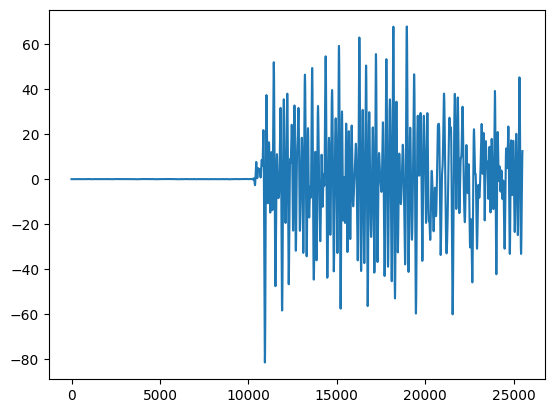

/tmp/ipykernel_4313/775378214.py:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data, dtype=np.float32)


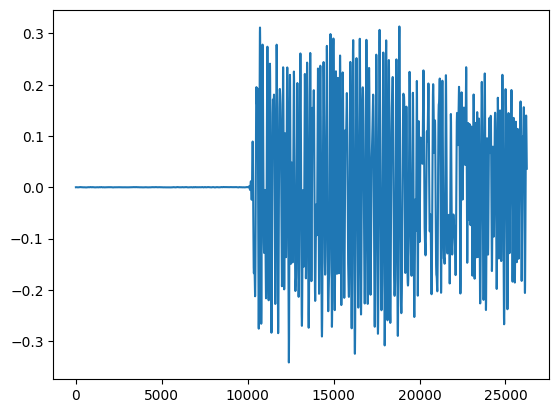

(151, 320)
[105  49  49  41 169 217 233 145 233 153 217  41  49 217 153  25  49 153
 217  49 217 128]
stop receiving


In [35]:
get_sound('file_out.txt')

In [ ]:
d = b'asskjdhvhfdksdfgsfds'
bits = get_bits(d)
enc = encode(G, bits)
dec = decode(H, enc, 10)
dec